# 画图：当客户端并不是从预训练参数开始的

In [88]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]SDRP_pre_ft")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [89]:
# filter out where name does not start with gpt2
runs_df = runs_df[runs_df['name'].str.startswith('gpt2')]

In [90]:
names = runs_df['name']
rouges = runs_df['summary'].apply(lambda x: x['client0_DRA_b2tr_rgLf_avg'])
rouges_bi = runs_df['summary'].apply(lambda x: x['client0_DLG_rgL_f_avg'])
pre_ft_epochs = runs_df['config'].apply(lambda x: x['pre_ft_max_steps'])
ppls = runs_df['summary'].apply(lambda x: x['client0_test-ppl'])

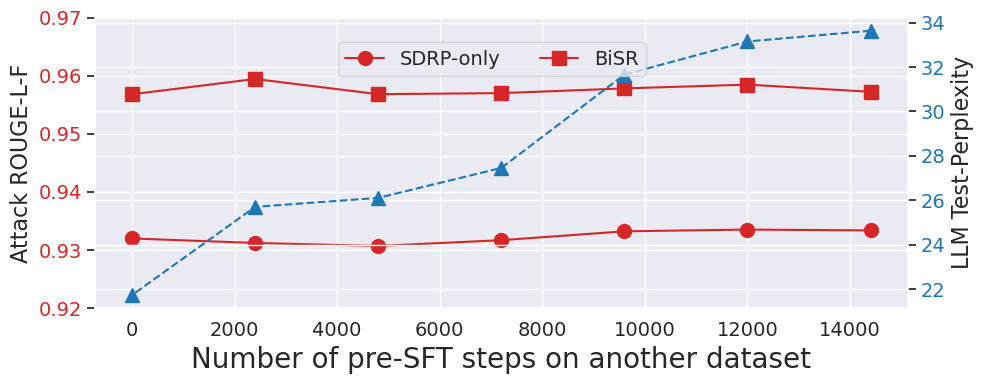

In [91]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

# create line figure with two y axis, one for ppl and one for rouge
fig, ax1 = plt.subplots(figsize=(10, 4))
# plot rouge
color = 'tab:red'
ax1.set_ylabel('Attack ROUGE-L-F',  fontsize=16)
ax1.plot(pre_ft_epochs, rouges, color=color, marker='o', markersize=10,label='SDRP-only')
# mark it square
ax1.plot(pre_ft_epochs, rouges_bi, color=color,marker='s', markersize=10,label='BiSR')
ax1.tick_params(axis='y', labelcolor=color,labelsize=14)
ax1.set_ylim(0.92, 0.97)
# plot ppl
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('LLM Test-Perplexity', fontsize=16)
ax2.plot(pre_ft_epochs, ppls, color=color, marker='^', markersize=10, linestyle='--')#,label='LLM-Test-Perplexity')
ax2.tick_params(axis='y', labelcolor=color,labelsize=14)
# ax2.set_ylim(20, 40)

# set X axis's label
ax1.set_xlabel('Number of pre-SFT steps on another dataset', fontsize=20)
ax1.tick_params(axis='x', labelsize=14)
# set legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fontsize=14)

# save the figure
plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/pre_ft.pdf')